In [1]:
cd ../analysis/

/home/jlee782/final_segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from PixelEM import * 

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# Pick best clusters for each object sample based on MV
best_clust_df = best_worker_picking()

clustObj=clust_df.objid.unique()

In [21]:
def plot_best_clust_thresh_metric(metric,gt="",includeObjs=[]):
    for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
        # we only ran on the best clusters, so the results should only be on the best clusters if not -1
        data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
        data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
        if includeObjs!=[]:
            data = data[data["objid"].isin(includeObjs)]
        #data = data[data["sample_num"]==0]
        plt.plot(data.groupby("num_workers").mean()[metric],label=algo)
        if includeObjs!=[]:
            try:
                assert len(data.objid.unique())==len(includeObjs)
            except(AssertionError):
                print len(data.objid.unique()),len(includeObjs)
        else:
            assert len(data.objid.unique())==len(object_lst)
    MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
    #MV = MV[MV["sample_num"]==0]
    # now need to filter based on best cluster
    MV = filter_best_clust(MV,best_clust_df)
    # select only the best cluster if clustered object -1 if not clustered
    MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]
    if includeObjs!=[]:
        MV = MV[MV["objid"].isin(includeObjs)]
    #MV[(MV["num_workers"]==5)&(MV["sample_num"]==9)].sort("objid")
    plt.plot(MV.groupby("num_workers").mean()[metric],label="MV clust",color="cyan",linestyle="--")
    MV_noClust = MV[MV["clust"]==-1].groupby("num_workers").mean()[metric]
    plt.plot(MV_noClust,label="MV no clust",color="black",linestyle="--")


    plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
    plt.ylabel(metric)
    plt.xticks(rotation=50)
    a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
    if gt:
        plt.title("Ground truth EM [best clust & thresh]",fontsize=13)
    else:
        plt.title("Binary Search Thresh EM [best clust & thresh]",fontsize=13)

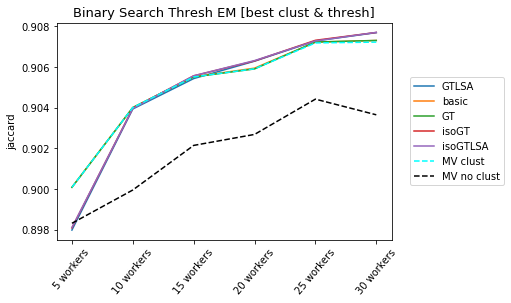

In [22]:
plot_best_clust_thresh_metric("jaccard")

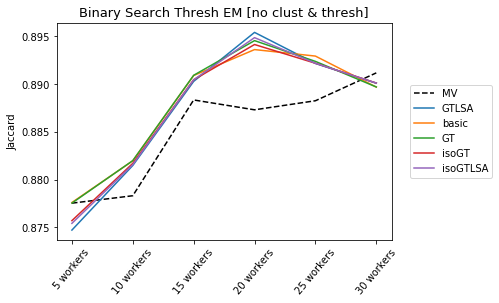

In [24]:
gt=""
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[(MV["clust"]==-1)]
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV",color="black",linestyle="--")
worker_df = pd.read_csv("pixel_em/individual_worker_performance.csv")
worker_df = worker_df[worker_df["clust"]==-1]
raw_worker_performance = worker_df.groupby("num_workers").mean()
# plt.plot(raw_worker_performance["avrg_j"],label="average worker")
# plt.plot(raw_worker_performance["max_j"],label="best worker")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[(data["clust"]==-1)]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
    assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [no clust & thresh]",fontsize=13)

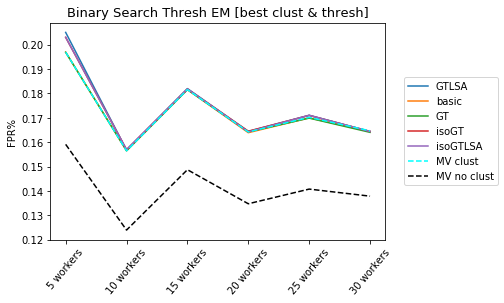

In [28]:
plot_best_clust_thresh_metric("FPR%")

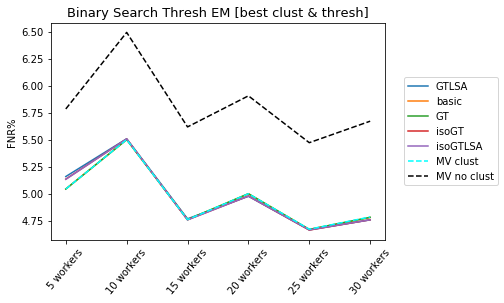

In [29]:
plot_best_clust_thresh_metric("FNR%")

# Baseline average worker, best worker

In [7]:
cat pixel_em/10workers_rand0/obj1/worker_ids.json

[52, 182, 118, 246, 140, 239, 149, 248, 170, 116]

In [8]:
from utils import * 

In [23]:
def compute_best_average_workers():
    computed_wrt_gt = pd.read_csv("../data/computed_my_COCO_BBvals.csv",index_col=0)
    sample_lst = sample_specs.keys()
    obj_clusters = clusters()
    df_data =[]
    for batch in sample_lst:
        for objid in object_lst:
            if str(objid) in obj_clusters[batch]:
                clusts = ["-1"] + [obj_clusters[batch][str(objid)]]
            else:
                clusts = ["-1"]
            for clust in clusts:
                hydir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, batch, objid)
                if clust=="-1":
                    worker_ids = json.load(open(hydir+"worker_ids.json"))
                else:
                    worker_ids= json.load(open(hydir+"/clust{}/worker_ids.json".format(clust)))
                avrg_p,avrg_r,avrg_j,avrg_fpr,avrg_fnr = computed_wrt_gt[(computed_wrt_gt["object_id"]==objid)&(computed_wrt_gt["worker_id"].isin(worker_ids))][['Precision [Self]', u'Recall [Self]','Jaccard [Self]','FPR [Self]','FNR [Self]']].mean()
                max_p,max_r,max_j,max_fpr,max_fnr = computed_wrt_gt[(computed_wrt_gt["object_id"]==objid)&(computed_wrt_gt["worker_id"].isin(worker_ids))][['Precision [Self]', u'Recall [Self]','Jaccard [Self]','FPR [Self]','FNR [Self]']].max()
                df_data.append([batch, objid,clust, avrg_p,avrg_r,avrg_j,avrg_fpr,avrg_fnr,max_p,max_r,max_j,max_fpr,max_fnr])
    df = pd.DataFrame(df_data,columns=["sample","objid","clust","avrg_p","avrg_r","avrg_j","avrg_fpr","avrg_fnr","max_p","max_r","max_j","max_fpr","max_fnr"])
    df["num_workers"]=df["sample"].apply(lambda x: int(x.split("workers")[0]))
    df.to_csv("pixel_em/individual_worker_performance.csv",index=None)
    return df

# Task difficulty

In [31]:
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
type_one_task_ambiguity = [15,20,22,27,31,40,41,42,47] #wrong object annotation
type_two_task_ambiguity = [1,4,7,8,9,10,18,20,21,25,28,29,30,31,32,33,34,35] #missing region

all_hard_tasks = list(set(np.concatenate((type_one_task_ambiguity,type_two_task_ambiguity))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]

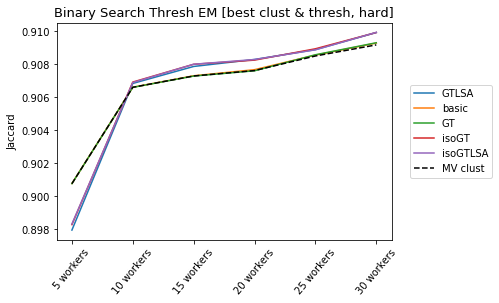

In [51]:
gt=""
for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
    data = data[data["objid"].isin(all_hard_tasks)]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]
worker_df = pd.read_csv("pixel_em/individual_worker_performance.csv")
worker_df = worker_df[((worker_df["clust"]==-1) &(worker_df["objid"].isin(noClust_obj)))| ((worker_df["clust"]!=-1) & worker_df["objid"].isin(clustObj))]
raw_worker_performance = worker_df.groupby("num_workers").mean()
MV=MV[MV["objid"].isin(all_hard_tasks)]
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV clust",color="black",linestyle="--")
# MV_noClust = MV[MV["clust"]==-1].groupby("num_workers").mean()["jaccard"]
# plt.plot(MV_noClust,label="MV no clust",color="black",linestyle="--")

plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [best clust & thresh, hard]",fontsize=13)

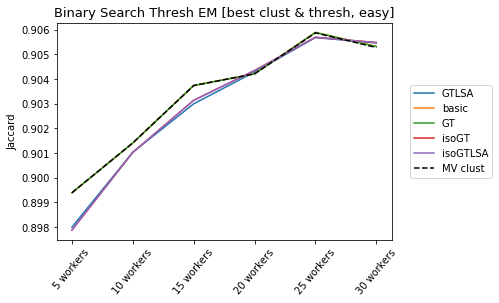

In [50]:
gt=""
for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
    data = data[data["objid"].isin(easy_tasks)]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]
worker_df = pd.read_csv("pixel_em/individual_worker_performance.csv")
worker_df = worker_df[((worker_df["clust"]==-1) &(worker_df["objid"].isin(noClust_obj)))| ((worker_df["clust"]!=-1) & worker_df["objid"].isin(clustObj))]
raw_worker_performance = worker_df.groupby("num_workers").mean()
MV=MV[MV["objid"].isin(easy_tasks)]
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV clust",color="black",linestyle="--")
# MV_noClust = MV[MV["clust"]==-1].groupby("num_workers").mean()["jaccard"]
# plt.plot(MV_noClust,label="MV no clust",color="black",linestyle="--")

plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [best clust & thresh, easy]",fontsize=13)

In [42]:
# plot_best_clust_thresh_metric("jaccard",gt="",includeObjs=all_hard_tasks)

# plot_best_clust_thresh_metric("jaccard",gt="",includeObjs=easy_tasks)

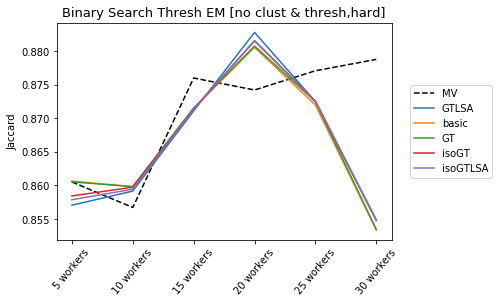

In [45]:
gt=""
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[(MV["clust"]==-1)]
MV = MV[MV["objid"].isin(all_hard_tasks)]
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV",color="black",linestyle="--")
worker_df = pd.read_csv("pixel_em/individual_worker_performance.csv")
worker_df = worker_df[worker_df["clust"]==-1]
raw_worker_performance = worker_df.groupby("num_workers").mean()
# plt.plot(raw_worker_performance["avrg_j"],label="average worker")
# plt.plot(raw_worker_performance["max_j"],label="best worker")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[(data["clust"]==-1)]
    data = data[data["objid"].isin(all_hard_tasks)]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
    #assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [no clust & thresh,hard]",fontsize=13)

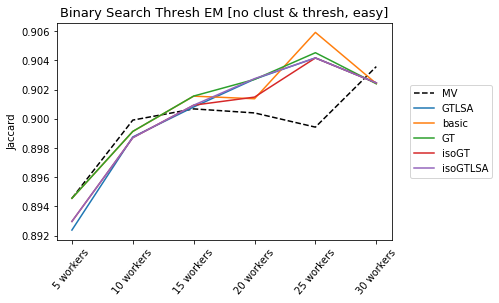

In [47]:
gt=""
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[(MV["clust"]==-1)]
MV = MV[MV["objid"].isin(easy_tasks)]
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV",color="black",linestyle="--")
worker_df = pd.read_csv("pixel_em/individual_worker_performance.csv")
worker_df = worker_df[worker_df["clust"]==-1]
raw_worker_performance = worker_df.groupby("num_workers").mean()
# plt.plot(raw_worker_performance["avrg_j"],label="average worker")
# plt.plot(raw_worker_performance["max_j"],label="best worker")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[(data["clust"]==-1)]
    data = data[data["objid"].isin(easy_tasks)]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
    #assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [no clust & thresh, easy]",fontsize=13)

---------------------------------------------------------------------------

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from PixelEM import * 

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [32]:
sample_name = "5workers_rand0"
objid =5 
cluster_id = -1
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True)

Doing EM
Loading time: 0.700685024261
computing qj based on model
iteration: 0
Time for worker prob calculation: 9.53674316406e-07
{9: 0.9987109375, 143: 0.9987239583333334, 247: 0.998955078125, 270: 0.9993229166666666, 199: 0.9978157552083333}
Time for mask log prob calculation: 18.1870229244
----Trying threshold: 50.0 -----
1.0 1.0 1.0 200 -100.0
actual prj against GT (0.9599246906939215, 0.8814522104223265, 0.8501667460695569)
Time for binary search : 0.0298750400543
{9: 0.9987109375, 143: 0.9987239583333334, 247: 0.998955078125, 270: 0.9993229166666666, 199: 0.9978157552083333}
-->[0.9599246906939215, 0.8814522104223265, 0.8501667460695569]
jaccard_against_prev_gt_est: 1.0
computing qj based on model
iteration: 1
Time for worker prob calculation: 9.53674316406e-07
{9: 0.9987109375, 143: 0.9987239583333334, 247: 0.998955078125, 270: 0.9993229166666666, 199: 0.9978157552083333}
Time for mask log prob calculation: 20.8397750854
----Trying threshold: 50.0 -----
1.0 1.0 1.0 200 -100.0
a

In [31]:
sample_name = "5workers_rand0"
objid =5 
cluster_id = -1
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True,initMethod="0.6constant")

Doing EM
Loading time: 0.502712965012
starting with q=0.6
iteration: 0
Time for worker prob calculation: 0.0
{9: 0.6, 143: 0.6, 247: 0.6, 270: 0.6, 199: 0.6}
Time for mask log prob calculation: 18.2749049664
----Trying threshold: 50.0 -----
1.0 1.0 1.0 200 -100.0
actual prj against GT (0.9599246906939215, 0.8814522104223265, 0.8501667460695569)
Time for binary search : 0.0387060642242
{9: 0.6, 143: 0.6, 247: 0.6, 270: 0.6, 199: 0.6}
-->[0.9599246906939215, 0.8814522104223265, 0.8501667460695569]
jaccard_against_prev_gt_est: 0.0
computing qj based on model
iteration: 1
Time for worker prob calculation: 9.53674316406e-07
{9: 0.9987109375, 143: 0.9987239583333334, 247: 0.998955078125, 270: 0.9993229166666666, 199: 0.9978157552083333}
Time for mask log prob calculation: 14.7780439854
----Trying threshold: 50.0 -----
1.0 1.0 1.0 200 -100.0
actual prj against GT (0.9599246906939215, 0.8814522104223265, 0.8501667460695569)
Time for binary search : 0.0204899311066
{9: 0.9987109375, 143: 0.9987

In [ ]:
pixel_em/5workers_rand0/obj5/gt_est_mask_best_thresh_0.6constant.pkl  
pixel_em/5workers_rand0/obj5/p_not_in_mask_best_thresh_0.6constant.pkl
pixel_em/5workers_rand0/obj5/p_in_mask_best_thresh_0.6constant.pkl

In [10]:
gt_est = pkl.load(open("pixel_em/5workers_rand0/obj5/gt_est_mask_best_thresh_0.6constant.pkl"))

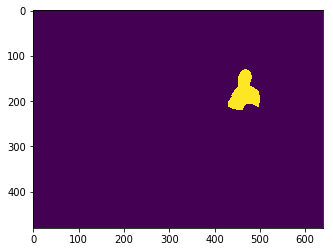

In [12]:
plt.imshow(gt_est)

In [13]:
faster_compute_prj(gt_est,get_gt_mask(5))

(0.9599246906939215, 0.8814522104223265, 0.8501667460695569)

In [14]:
cat pixel_em/5workers_rand0/obj5/MV_prj.json

[0.9599246906939215, 0.8814522104223265, 0.8501667460695569]

In [15]:
cat pixel_em/5workers_rand0/obj5/EM_prj_best_thresh.json

[0.9599246906939215, 0.8814522104223265, 0.8501667460695569]

In [33]:
sample_name = "10workers_rand0"
objid =10
cluster_id = -1
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True)

Doing EM
Loading time: 0.324685096741
computing qj based on model
iteration: 0
Time for worker prob calculation: 0.0
{260: 0.9969951923076923, 230: 0.9978170478170478, 140: 0.9982718295218295, 205: 0.9980866683991684, 142: 0.9989085239085239, 148: 0.9988760395010395, 149: 0.9989929833679834, 116: 0.9980736746361747, 218: 0.9953969594594595, 223: 0.9980639293139293}
Time for mask log prob calculation: 26.4102389812
----Trying threshold: 50.0 -----
0.995939813709 1.0 0.995939813709 200 -100.0
actual prj against GT (0.9812514927155481, 0.9742130535301441, 0.9564104056334749)
----Trying threshold: 12.5 -----
1.0 0.957254196643 0.957254196643 125.0 -100.0
actual prj against GT (0.9959917329492077, 0.9427351947359061, 0.9391720309454911)
----Trying threshold: -15.625 -----
1.0 0.996582733813 0.996582733813 68.75 -100.0
actual prj against GT (0.9848402815376286, 0.9704783923172684, 0.956194147538111)
----Trying threshold: 5.46875 -----
0.978988144148 1.0 0.978988144148 68.75 -57.8125
actual p

In [34]:
sample_name = "10workers_rand0"
objid = 10
cluster_id = -1
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True,initMethod="0.6constant")

Doing EM
Loading time: 0.715595006943
starting with q=0.6
iteration: 0
Time for worker prob calculation: 1.19209289551e-06
{260: 0.6, 230: 0.6, 140: 0.6, 205: 0.6, 142: 0.6, 148: 0.6, 149: 0.6, 116: 0.6, 218: 0.6, 223: 0.6}
Time for mask log prob calculation: 27.4085509777
----Trying threshold: 50.0 -----
0.993271005776 1.0 0.993271005776 200 -100.0
actual prj against GT (0.9789197880069076, 0.9745094552137056, 0.9544794751204785)
----Trying threshold: 5.0 -----
-1 0.0 0.0 35.0 -25.0
actual prj against GT (-1, 0.0, 0.0)
----Trying threshold: -4.0 -----
-1 0.0 0.0 2.0 -10.0
actual prj against GT (-1, 0.0, 0.0)
----Trying threshold: -2.5 -----
0.926924145596 1.0 0.926924145596 2.0 -7.0
actual prj against GT (0.9368157821617116, 0.9993479162961646, 0.9362434743974231)
----Trying threshold: -1.375 -----
0.956147893379 1.0 0.956147893379 2.0 -4.75
actual prj against GT (0.9584408139868157, 0.9911672298298654, 0.9503239740820735)
----Trying threshold: -0.53125 -----
0.978988144148 1.0 0.9789

In [35]:
cat pixel_em/10workers_rand0/obj10/MV_prj.json

[0.9829736211031175, 0.9719604007350762, 0.9558677782312132]

In [36]:
cat pixel_em/10workers_rand0/obj10/EM_prj_best_thresh.json

[0.9829736211031175, 0.9719604007350762, 0.9558677782312132]

In [38]:
sample_name = "10workers_rand0"
objid =10
cluster_id = 0
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True)

Doing EM
Loading time: 0.590570926666
computing qj based on model
iteration: 0
Time for worker prob calculation: 9.53674316406e-07
{260: 0.9969951923076923, 230: 0.9978170478170478, 140: 0.9982718295218295, 205: 0.9980866683991684, 142: 0.9989085239085239, 148: 0.9988760395010395, 149: 0.9989929833679834, 116: 0.9980736746361747, 218: 0.9953969594594595, 223: 0.9980639293139293}
Time for mask log prob calculation: 20.0065281391
----Trying threshold: 50.0 -----
0.995939813709 1.0 0.995939813709 200 -100.0
actual prj against GT (0.9812514927155481, 0.9742130535301441, 0.9564104056334749)
----Trying threshold: 12.5 -----
1.0 0.957254196643 0.957254196643 125.0 -100.0
actual prj against GT (0.9959917329492077, 0.9427351947359061, 0.9391720309454911)
----Trying threshold: -15.625 -----
1.0 0.996582733813 0.996582733813 68.75 -100.0
actual prj against GT (0.9848402815376286, 0.9704783923172684, 0.956194147538111)
----Trying threshold: 5.46875 -----
0.978988144148 1.0 0.978988144148 68.75 -57

In [37]:
sample_name = "10workers_rand0"
objid = 10
cluster_id = 0
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True,initMethod="0.6constant")

Doing EM
Loading time: 0.757363080978
starting with q=0.6
iteration: 0
Time for worker prob calculation: 0.0
{260: 0.6, 230: 0.6, 140: 0.6, 205: 0.6, 142: 0.6, 148: 0.6, 149: 0.6, 116: 0.6, 218: 0.6, 223: 0.6}
Time for mask log prob calculation: 41.2504489422
----Trying threshold: 50.0 -----
0.993271005776 1.0 0.993271005776 200 -100.0
actual prj against GT (0.9789197880069076, 0.9745094552137056, 0.9544794751204785)
----Trying threshold: 5.0 -----
-1 0.0 0.0 35.0 -25.0
actual prj against GT (-1, 0.0, 0.0)
----Trying threshold: -4.0 -----
-1 0.0 0.0 2.0 -10.0
actual prj against GT (-1, 0.0, 0.0)
----Trying threshold: -2.5 -----
0.926924145596 1.0 0.926924145596 2.0 -7.0
actual prj against GT (0.9368157821617116, 0.9993479162961646, 0.9362434743974231)
----Trying threshold: -1.375 -----
0.956147893379 1.0 0.956147893379 2.0 -4.75
actual prj against GT (0.9584408139868157, 0.9911672298298654, 0.9503239740820735)
----Trying threshold: -0.53125 -----
0.978988144148 1.0 0.978988144148 2.0 -

In [39]:
cat pixel_em/10workers_rand0/obj10/clust0/MV_prj.json

[0.9796076560729832, 0.9739166518465825, 0.9545639416652141]

In [40]:
sample_name = "30workers_rand0"
objid = 15
cluster_id = -1
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True,initMethod="0.6constant")

Doing EM
Loading time: 0.537504911423
starting with q=0.6
iteration: 0
Time for worker prob calculation: 0.0
{129: 0.6, 130: 0.6, 131: 0.6, 133: 0.6, 137: 0.6, 142: 0.6, 143: 0.6, 272: 0.6, 148: 0.6, 150: 0.6, 156: 0.6, 242: 0.6, 46: 0.6, 51: 0.6, 52: 0.6, 181: 0.6, 54: 0.6, 9: 0.6, 56: 0.6, 60: 0.6, 61: 0.6, 68: 0.6, 218: 0.6, 223: 0.6, 225: 0.6, 230: 0.6, 241: 0.6, 114: 0.6, 116: 0.6, 16: 0.6}
Time for mask log prob calculation: 82.1445829868
----Trying threshold: 50.0 -----
0.989492119089 1.0 0.989492119089 200 -100.0
actual prj against GT (0.8563922942206655, 0.9625984251968503, 0.8288135593220339)
----Trying threshold: 5.0 -----
-1 0.0 0.0 35.0 -25.0
actual prj against GT (-1, 0.0, 0.0)
----Trying threshold: -2.5 -----
1.0 0.787610619469 0.787610619469 20.0 -25.0
actual prj against GT (0.9662921348314607, 0.8464566929133859, 0.8221797323135756)
----Trying threshold: 3.125 -----
0.906902086677 1.0 0.906902086677 20.0 -13.75
actual prj against GT (0.8057784911717496, 0.9881889763779

In [41]:
cat pixel_em/30workers_rand0/obj15/MV_prj.json

[0.8654867256637168, 0.9625984251968503, 0.8373287671232876]

In [42]:
cat pixel_em/30workers_rand0/obj15/EM_prj_best_thresh.json

[0.8654867256637168, 0.9625984251968503, 0.8373287671232876]

In [56]:
data =  pd.read_csv("pixel_em/basic_full_PRJ_table.csv")
MV =  pd.read_csv("pixel_em/MV_full_PRJ_table.csv")
MV = filter_best_clust(MV,best_clust_df)

In [57]:
data.head()

,num_workers,sample_num,objid,thresh,clust,precision,recall,jaccard,FPR%,FNR%
0,25,0,1,best,0,0.984171,0.985411,0.970036,0.147678,1.458906
1,25,0,1,best,-1,0.986507,0.980102,0.967138,0.124904,1.989765
2,25,0,2,best,-1,0.956827,0.981829,0.940178,0.098156,1.817090
3,25,0,3,best,-1,0.954869,0.916754,0.878681,0.054385,8.324580
4,25,0,4,best,0,0.946651,0.946364,0.898446,0.057914,5.363636


In [58]:
MV.head()

,num_workers,sample_num,objid,thresh,clust,precision,recall,jaccard,FPR%,FNR%
0,25,0,1,best,0,0.984171,0.985411,0.970036,0.147678,1.458906
2,25,0,1,best,-1,0.986239,0.979873,0.966657,0.127395,2.012679
3,25,0,2,best,-1,0.956827,0.981829,0.940178,0.098156,1.817090
4,25,0,3,best,-1,0.954869,0.916754,0.878681,0.054385,8.324580
5,25,0,4,best,0,0.946651,0.946364,0.898446,0.057914,5.363636


In [59]:
sample_name = "25workers_rand0"
objid = 1
cluster_id = -1
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True,initMethod="0.6constant")

Doing EM
Loading time: 0.476587057114
starting with q=0.6
iteration: 0
Time for worker prob calculation: 0.0
{133: 0.6, 137: 0.6, 140: 0.6, 146: 0.6, 148: 0.6, 156: 0.6, 170: 0.6, 175: 0.6, 52: 0.6, 181: 0.6, 196: 0.6, 246: 0.6, 199: 0.6, 201: 0.6, 75: 0.6, 219: 0.6, 223: 0.6, 234: 0.6, 238: 0.6, 239: 0.6, 114: 0.6, 116: 0.6, 118: 0.6, 247: 0.6, 248: 0.6}
Time for mask log prob calculation: 93.3806948662
----Trying threshold: 50.0 -----
1.0 1.0 1.0 200 -100.0
actual prj against GT (0.98623870843744, 0.9798732050106935, 0.9666566196970838)
Time for binary search : 0.0327432155609
{133: 0.6, 137: 0.6, 140: 0.6, 146: 0.6, 148: 0.6, 156: 0.6, 170: 0.6, 175: 0.6, 52: 0.6, 181: 0.6, 196: 0.6, 246: 0.6, 199: 0.6, 201: 0.6, 75: 0.6, 219: 0.6, 223: 0.6, 234: 0.6, 238: 0.6, 239: 0.6, 114: 0.6, 116: 0.6, 118: 0.6, 247: 0.6, 248: 0.6}
-->[0.98623870843744, 0.9798732050106935, 0.9666566196970838]
jaccard_against_prev_gt_est: 0.0
computing qj based on model
iteration: 1
Time for worker prob calculat

Time for mask log prob calculation: 94.8385028839
----Trying threshold: 50.0 -----
0.998540538464 0.999384970209 0.997927302038 200 -100.0
actual prj against GT (0.9864039635902754, 0.9808661778185152, 0.9677820483834502)
----Trying threshold: 12.5 -----
1.0 0.973246204113 0.973246204113 125.0 -100.0
actual prj against GT (0.9942730755559066, 0.961426825542316, 0.956132021725094)
----Trying threshold: -15.625 -----
1.0 0.993426869114 0.993426869114 68.75 -100.0
actual prj against GT (0.9889336016096579, 0.9760922700886038, 0.9655459010200227)
----Trying threshold: 5.46875 -----
0.988449409172 1.0 0.988449409172 68.75 -57.8125
actual prj against GT (0.9813442759983282, 0.9864039107852124, 0.9682474226804124)
----Trying threshold: -10.3515625 -----
1.0 0.998885258505 0.998885258505 37.109375 -57.8125
actual prj against GT (0.9866466558916339, 0.9791857622975864, 0.9663789529229957)
----Trying threshold: 1.513671875 -----
0.993166373979 1.0 0.993166373979 37.109375 -34.08203125
actual prj

In [19]:
from useVision import *

In [22]:
sample_name="5workers_rand0"
objid=1
k=500
expand_thresh=0.8
contract_thresh=0.2
outdir = hybrid_dir(sample_name, objid, k, expand_thresh, contract_thresh)

In [25]:
hybrid_mask = pkl.load(open(outdir+"/MV_-1_hybrid_mask.pkl"))

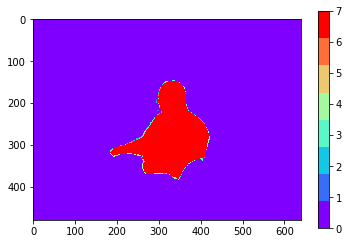

In [34]:
MV_mask = get_MV_mask(sample_name, objid)
gt_mask = get_gt_mask(objid)
    sum_mask = hybrid_mask.astype(int) * 1 + MV_mask.astype(int) * 2 + gt_mask.astype(int) * 4

    plt.figure()
    plt.imshow(sum_mask, interpolation="none",cmap=discrete_cmap(8, 'rainbow'))  # , cmap="rainbow")
    plt.colorbar()